### Not Suitable due to the way poisson generative process works in GAP

In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlockv3_noinp import UN
from BinomDatasetv4_noinp import BinomDataset
from inferencev2 import sample_image
from tasks import inpainting

In [2]:
name = 'm40tom5-256x256-base-inpainting-only-cond-inp-no-noisyimage'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'


model = UN(channels = 1, levels=10, depth=6, 
           start_filts=28, up_mode = 'upsample', merge_mode = 'concat').to(device)
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [20]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

(1, 512, 512)


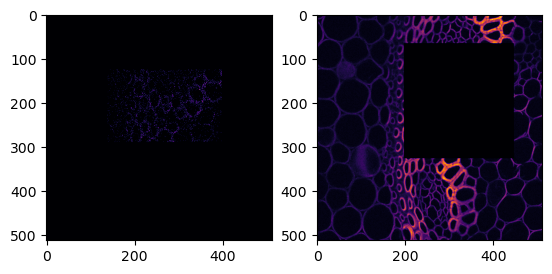

In [15]:
masks = inpainting(imgsize = 512, masksize = 300)
mask = masks.generate_mask().numpy()
test = dataTest 
testGT = dataTestGT#/dataTestGT.mean()
cond_test = testGT * (1 - mask)
print(cond_test.shape)
plt.subplot(1, 2, 1)
plt.imshow(test[0], 'inferno')
plt.subplot(1, 2, 2)
plt.imshow(cond_test[0], 'inferno')

(2, 512, 512)
input shape : torch.Size([2, 512, 512]), model input shape : torch.Size([1, 2, 512, 512])
332 0 44.3373404001294 272.0 17.0
inp shape : (512, 512)
out shape : torch.Size([1, 1, 512, 512])
gt shape : (512, 512)


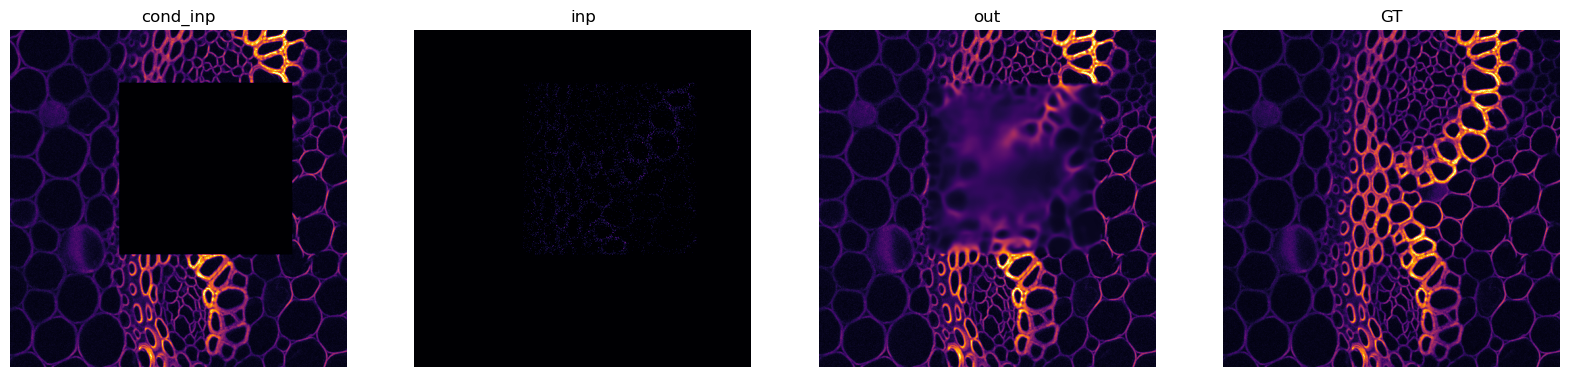

In [41]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
masks = inpainting(imgsize = 512, masksize = 300)
mask = masks.generate_mask().numpy()
dataTest = dataTest * mask 
testGT = dataTestGT#/dataTestGT.mean()
cond_test = (testGT * (1 - mask)) 
cond_test2 = cond_test + np.zeros_like(dataTest)

outputs = []
cond_input = np.expand_dims(np.concatenate((mask, cond_test2), axis = 0), axis = 0)
for inp, cinp, gt in zip(dataTest, cond_input, dataTestGT): 
    print(cinp.shape) 
    inpT = torch.from_numpy((inp).astype(np.float32)).to(device) 
    cond_inpT = torch.from_numpy((cinp).astype(np.float32)).to(device)
    inpT = (cond_inpT).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    out = torch.exp(model(inpT[None]).detach().cpu())
    out = inp.sum() * out / out.sum() ## multiply noisy image with probability distribution of clean image?
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    cond_inp = cinp[1]/cinp[1].mean()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    cond_vmax = np.percentile(cond_test,99.9)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    plt.imshow(cond_test[0] ,vmin = 0, vmax = cond_vmax, cmap = "inferno")
    plt.title('cond_inp')
    plt.axis('off')

    vmax = np.percentile(gt,99.9)
    plt.subplot(1, 4, 2)
    plt.imshow(dataTest[0],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(out[0,0],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(gt,vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.axis('off')
    plt.show()
    


input_img shape torch.Size([1, 2, 512, 512])
input_img shape torch.float32
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 1, 512, 512])



torch.Size([1, 1, 512, 512])

Max : 3.8330315874191e-05
Min : 2.8436869570214185e-07
Mean : 3.814697265625e-06
Sum : 1.0


Max : 322.0
Min : 0.0
Mean : 19.774616241455078
Sum : 5183797.0

torch.Size([1, 1, 512, 512])
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 1, 512, 512])



torch.Size([1, 1, 512, 512])

Max : 4.676604658016004e-05
Min : 3.296660224805237e-07
Mean : 3.814697265625e-06
Sum : 1.0


Max : 323.0
Min : 0.0
Mean : 19.97256851196289
Sum : 5235689.0

torch.Size([1, 1, 512, 512])
cond_input shape : torch.Size([1, 1, 512, 512])
photons shape: torch.Size([1, 1, 512, 512])



torch.Size([1, 1, 512, 512])

Max : 4.515468390309252e-05
Min : 3.277846758464875e-07
Mean : 3.814697265625e-06
Sum : 1.0


Max : 327.0
Min : 0.0
Mean : 20.172012329101562
Sum : 5287972.0

torch.Size([1, 1,

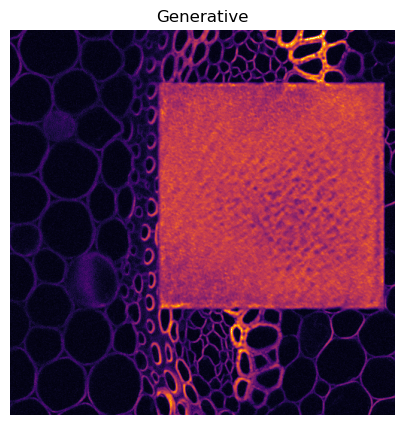

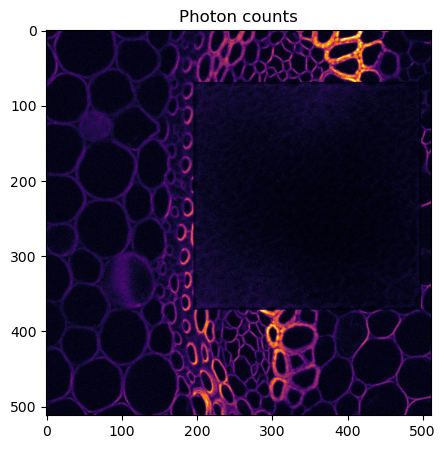

_______________________________________ 48
time (s): 2.6503071784973145 time per image (s) 2.6503071784973145


In [39]:
import matplotlib.image as mpimg
import time
import numpy as np
from inferencev3 import sample_image

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 512
pixels_y = 512

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x)
# masks2 = inpainting(imgsize = 512, masksize = 500)
# mask = masks2.generate_mask().numpy()
cond_input = np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0)

cond_img = torch.from_numpy(cond_input).to(torch.float32)
# cond_img = torch.zeros_like(cond_img)
input_img = torch.cat((cond_img, inp_img), 1).to(device)
input_img = cond_img.to(device)
print(f'input_img shape {input_img.shape}')
print(f'input_img shape {input_img.dtype}')


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(input_img,
                                                        model, 
                                                        beta = 0.01,
                                                        save_every_n = 10,
                                                        max_psnr = 15,
                                                        max_its = 7000000)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)

            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Generative')
            plt.axis('off')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

0


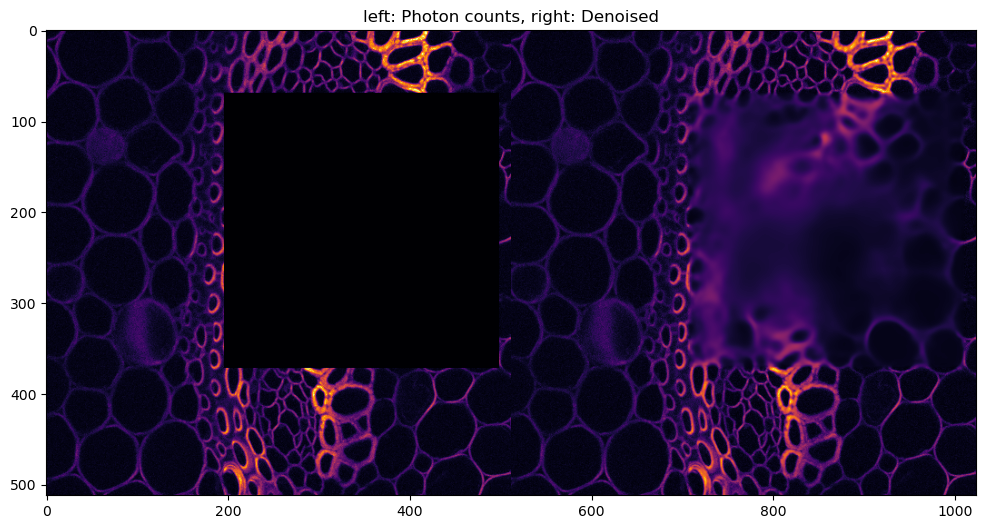

1


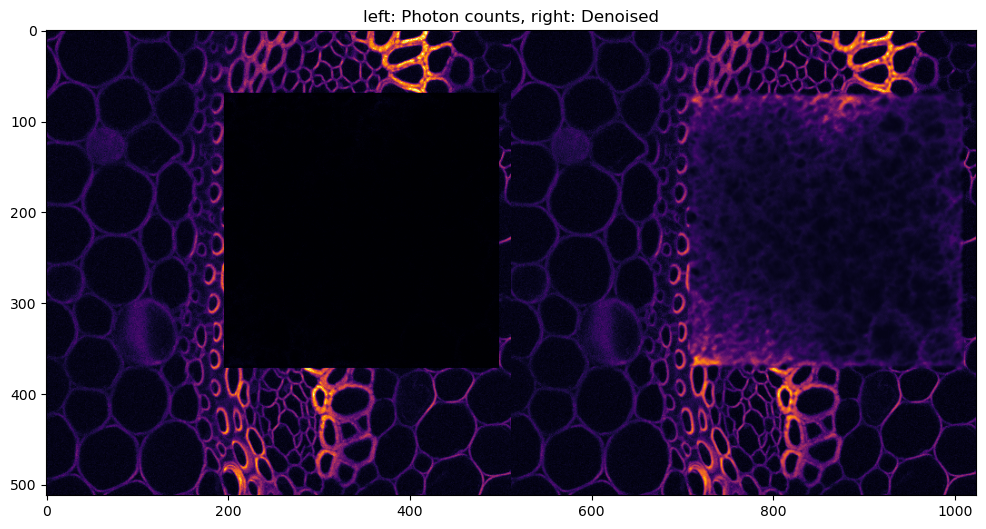

2


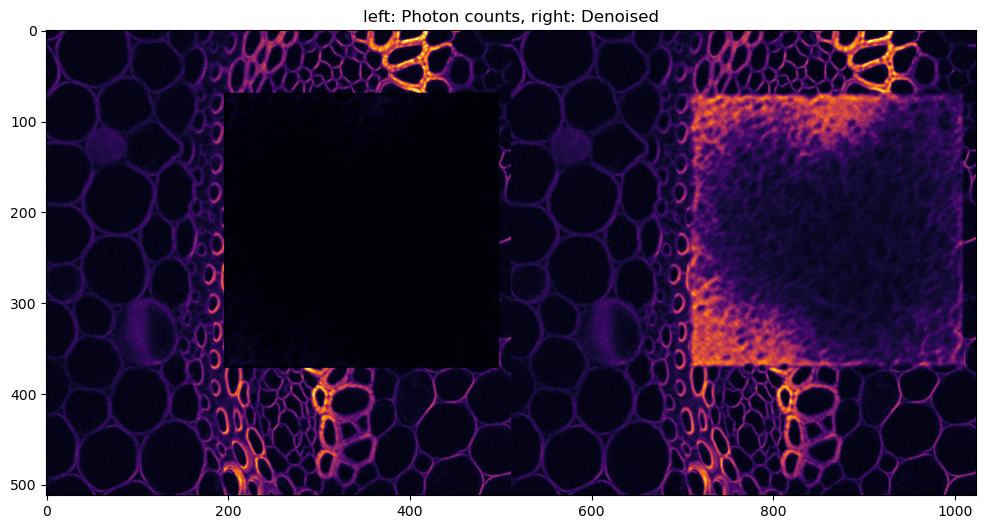

3


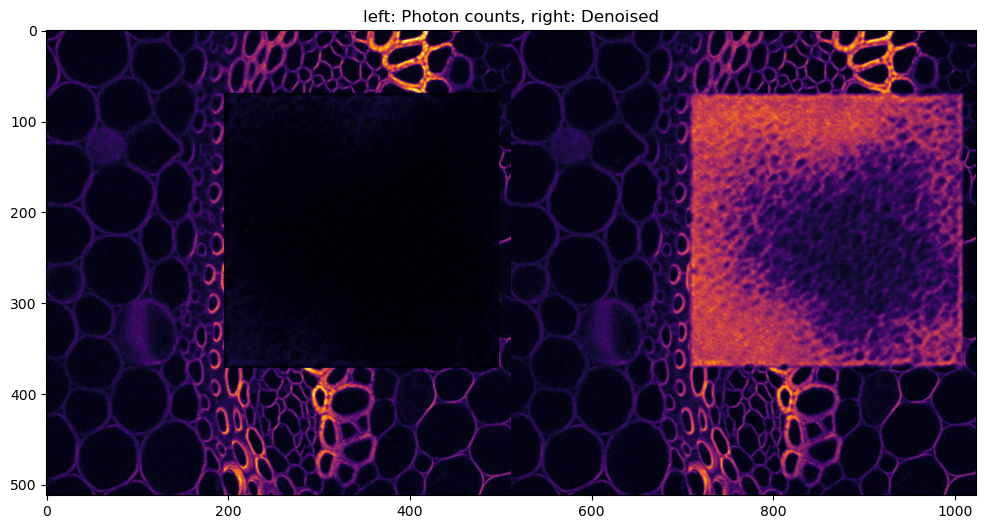

4


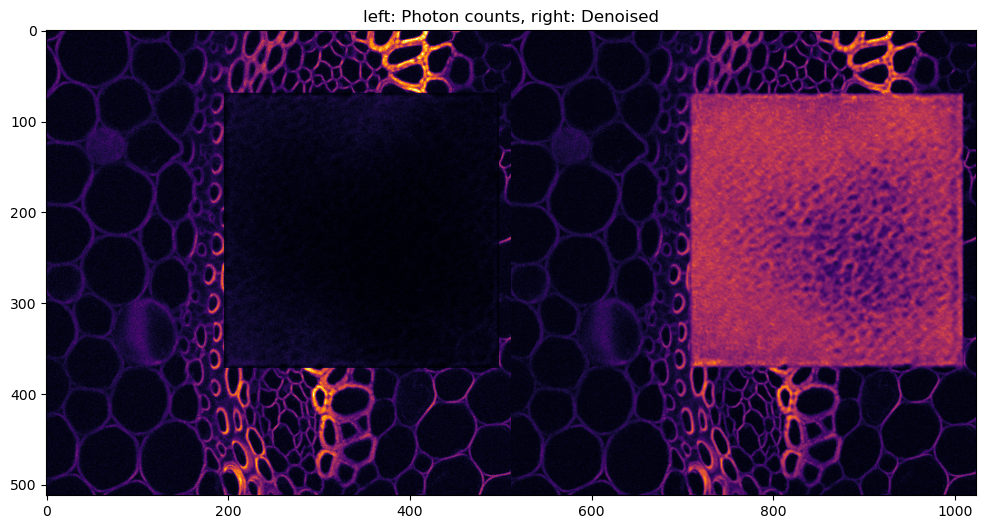

In [40]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='inferno', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()